In [1]:
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

<h3 ><font color='blue'>preparing the datasetes and library</font>

In [3]:
# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [5]:
# Hyper parameters
num_epochs = 5
num_classes = 10
batch_size = 100
learning_rate = 0.001

In [7]:
# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data/',
                                           train=True,
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='./data/',
                                          train=False,
                                          download=True,
                                          transform=transforms.ToTensor())

100.1%

Extracting ./data/MNIST\raw\train-images-idx3-ubyte.gz to ./data/MNIST\raw


0.0%

113.5%

Extracting ./data/MNIST\raw\train-labels-idx1-ubyte.gz to ./data/MNIST\raw


100.4%

Extracting ./data/MNIST\raw\t10k-images-idx3-ubyte.gz to ./data/MNIST\raw


180.4%C:\Users\pc\anaconda3\envs\pytorch_env\lib\site-packages\torchvision\datasets\mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Extracting ./data/MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data/MNIST\raw
Processing...
Done!


In [8]:
# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False)

In [15]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 

Feature batch shape: torch.Size([100, 1, 28, 28])
Labels batch shape: torch.Size([100])


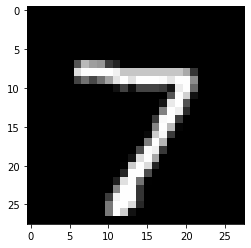

Label: 7


In [16]:
# Display image and label.
train_features, train_labels = next(iter(test_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

<h3 ><font color='blue'>Convolutional neural network structure (two convolutional layers)</font>

In [17]:
# Convolutional neural network (two convolutional layers)
class ConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(7*7*32, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

model = ConvNet(num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


<h3 ><font color='blue'>Train the model</font>

In [18]:
# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))


Epoch [1/5], Step [100/600], Loss: 0.1116
Epoch [1/5], Step [200/600], Loss: 0.0919
Epoch [1/5], Step [300/600], Loss: 0.0945
Epoch [1/5], Step [400/600], Loss: 0.0242
Epoch [1/5], Step [500/600], Loss: 0.0276
Epoch [1/5], Step [600/600], Loss: 0.1494
Epoch [2/5], Step [100/600], Loss: 0.0359
Epoch [2/5], Step [200/600], Loss: 0.1329
Epoch [2/5], Step [300/600], Loss: 0.0529
Epoch [2/5], Step [400/600], Loss: 0.0380
Epoch [2/5], Step [500/600], Loss: 0.0137
Epoch [2/5], Step [600/600], Loss: 0.0651
Epoch [3/5], Step [100/600], Loss: 0.0161
Epoch [3/5], Step [200/600], Loss: 0.0216
Epoch [3/5], Step [300/600], Loss: 0.0134
Epoch [3/5], Step [400/600], Loss: 0.0762
Epoch [3/5], Step [500/600], Loss: 0.0193
Epoch [3/5], Step [600/600], Loss: 0.0148
Epoch [4/5], Step [100/600], Loss: 0.0158
Epoch [4/5], Step [200/600], Loss: 0.0161
Epoch [4/5], Step [300/600], Loss: 0.0229
Epoch [4/5], Step [400/600], Loss: 0.0038
Epoch [4/5], Step [500/600], Loss: 0.0128
Epoch [4/5], Step [600/600], Loss:

<h3 ><font color='blue'>Test the model</font>

In [20]:
# Test the model
model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

Test Accuracy of the model on the 10000 test images: 98.73 %


<h3 ><font color='blue'>Save the model checkpoint</font>

In [23]:
# Save the model checkpoint
torch.save(model.state_dict(), 'modelCNN_pytorch.ckpt')